# Speech Understanding 
# Lecture 9: Fourier Analysis of Synthetic Speech



### Mark Hasegawa-Johnson, KCGI

In today's lecture, we will use <a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html">numpy.fft</a> to perform Fourier analysis of synthetic speech.

Here are the contents:
1. [Fourier analysis of the excitation (impulse train)](#section1)
1. [Fourier analysis of an /a/](#section2)
1. [Fourier analysis of different vowels](#section3)
1. [Homework](#homework)

<a id='section1'></a>

## 1.  Fourier analysis of the excitation (impulse train)

* On 6/06, we learned how to synthesize speech.  
* On 6/13, we learned how to use Fourier analysis to find out which pure tones are part of a musical chord.

Let's combine those, to find out which pure tones are part of synthetic speech.  We'll start with a voiced excitation signal.  This signal is also called an **impulse train**, because it is a sequence of one-sample impulses:

Text(0.5, 0, 'Time (samples)')

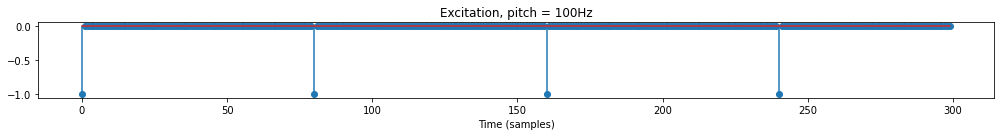

In [1]:
import numpy as np
Fs = 8000
F0 = 100
T0 = int(np.round(Fs/F0))
excitation = np.zeros(8000)
excitation[::T0] = -1

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,2),layout='tight')
subplot = fig.subplots(1,1)
subplot.stem(excitation[:300])
subplot.set_title('Excitation, pitch = %dHz'%(F0))
subplot.set_xlabel('Time (samples)')

In [2]:
import IPython
IPython.display.Audio(data=excitation, rate=Fs)

Let's try taking the Fourier transform.  Remember that 

$$f = \left(\frac{F_s}{N}\right)k,$$

* $k$ = DFT bin number
* $f$ = frequency in Hertz
* $F_s$ = sampling frequency (samples/second)
* $N$ = length of the DFT

In this case, we'll use a DFT of length $N=F_s=8000$, so that $k=f$.

Text(0.5, 0, 'Frequency (Hertz)')

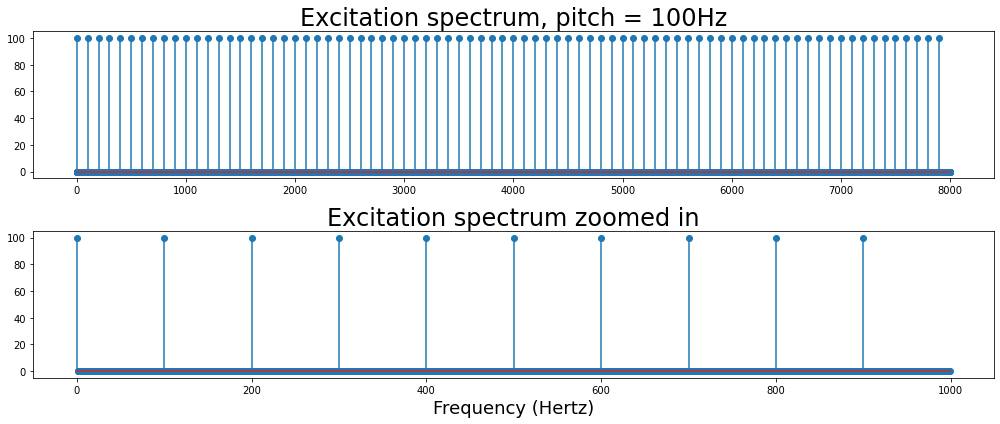

In [3]:
excitation_fft = np.fft.fft(excitation)

fig = plt.figure(figsize=(14,6),layout='tight')
subplot = fig.subplots(2,1)
subplot[0].stem(np.abs(excitation_fft))
subplot[0].set_title('Excitation spectrum, pitch = %dHz'%(F0),fontsize=24)
subplot[1].stem(np.abs(excitation_fft[:1000]))
subplot[1].set_title('Excitation spectrum zoomed in',fontsize=24)
subplot[1].set_xlabel('Frequency (Hertz)',fontsize=18)

Surprise!  **The DFT of an impulse train (with period T0) is an impulse train (with period F0)!**.

Last time, we interpreted every impulse in frequency to be a **pure tone component** of a musical chord.  By that interpretation, it seems that voiced speech has a pure tone component at every integer multiple of $F_0$, i.e.,

$$\sum_{\ell} \cos\left(\frac{2\pi \ell n}{T_0}\right)$$

Let's try reconstructing the excitation that way, and see if it comes out the same.

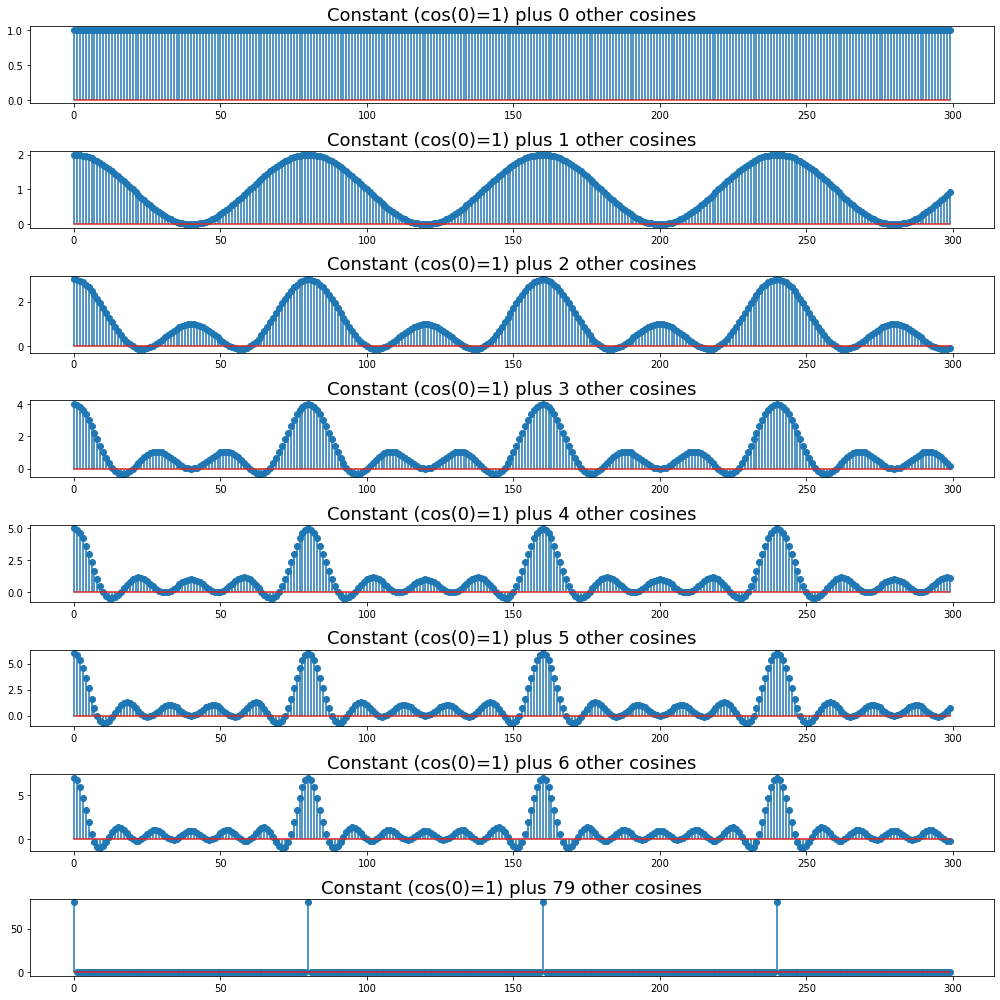

In [4]:
e = np.zeros(8000)
n = np.arange(8000)

fig = plt.figure(figsize=(14,14),layout='tight')
subplot = fig.subplots(8,1)

for l in range(T0):
    e = e + np.cos(2*np.pi*l*n/T0)
    if l < 7 or l > T0-2:
        subplot[l%8].stem(e[:300])
        subplot[l%8].set_title('Constant (cos(0)=1) plus %d other cosines'%(l),fontsize=18)
    

So we can see that the voiced excitation really is a sum of cosines at every integer multiple of $F_0$!  We can write this as 

$$\sum_{m}\delta[n-mT_0] = \frac{1}{T_0}\sum_{l} \cos\left(\frac{2\pi ln}{T_0}\right)$$

... where the symbol $\delta[n]$ is called the **impulse** or the **delta function,** and is defined as

$$\delta[n]=\left\{\begin{array}{ll}1&n=0\\0&\mbox{otherwise}\end{array}\right.$$

Each of the pure tones in the harmonic is called a **harmonic** of the pitch.  To get a better feeling for this, let's try listening to voiced excitation including different numbers of harmonics.  Try adjusting the following by setting `number_of_harmonics` to different numbers between 1 and 80:

In [5]:
e = np.zeros(8000)
n = np.arange(8000)

number_of_harmonics = 80

for l in range(number_of_harmonics):
    e = e + np.cos(2*np.pi*l*n/T0)
    
IPython.display.Audio(data=e,rate=Fs)

<a id='section2'></a>

## 2. Fourier analysis of an /a/

Let's try making a synthetic /a/, and see what is its spectrum.  Remember that first we need to create a resonator:

In [6]:
def resonator(x,F,BW,Fs):
    C = -np.exp(-2*np.pi*BW/Fs)
    B = 2 * np.exp(-np.pi*BW/Fs) * np.cos(2*np.pi*F/Fs)
    A = 1 - B - C
    y = np.zeros(len(x))
    y[0] = A*x[0]
    y[1] = A*x[1] + B*y[0]
    for n in range(2,len(y)):
        y[n] = A*x[n] + B*y[n-1] + C*y[n-2]
    return y


Then we need to give it the formant frequencies shown in this figure:

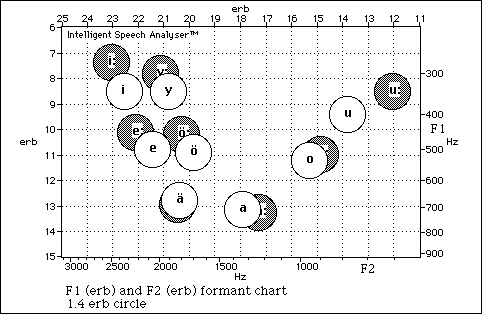

In [7]:
x1 = resonator(excitation,700,100,Fs)
x2 = resonator(x1,1300,200,Fs)
x3 = resonator(x2,2500,300,Fs)
speech = resonator(x3,3500,400,Fs)

IPython.display.Audio(data=speech,rate=Fs)

Since we have formant frequencies up to $\frac{F_s}{2}=4000$Hz, let's just plot that part of the spectrum.

Text(0.5, 0, 'Frequency (Hertz)')

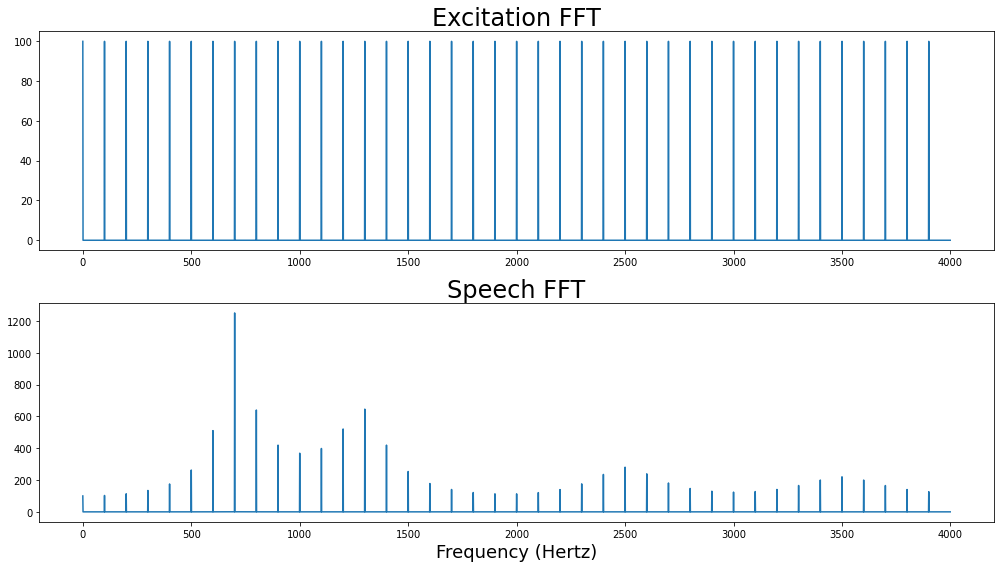

In [8]:
speech_fft = np.fft.fft(speech)

fig=plt.figure(figsize=(14,8),layout='tight')
subplot=fig.subplots(2,1)
subplot[0].plot(np.abs(excitation_fft[:4000]))
subplot[0].set_title('Excitation FFT',fontsize=24)
subplot[1].plot(np.abs(speech_fft[:4000]))
subplot[1].set_title('Speech FFT',fontsize=24)
subplot[1].set_xlabel('Frequency (Hertz)',fontsize=18)

Notice that:

* The **excitation FFT** has peaks at every harmonic of $F_0$
* The **speech FFT** has those same peaks, but their amplitudes are scaled

Specifically, the amplitude of a harmonic is scaled up whenever it is **near a formant frequency**

* The harmonic at $F_1=700$ has a high amplitude
* The harmonic at $F_2=1300$ has a high amplitude
* The harmonic at $F_3=2500$ has a high amplitude
* The harmonic at $F_4=3500$ has a high amplitude

These peaks are caused by the speech resonances.  Notice also that the amplitudes of the peaks are scaled up by  $\text{constant}/BW$ for some constant:

* The BW of the first formant is $BW=100$, and its amplitude is 1200
* The BW of the second formant is $BW=200$, and its amplitude is $\frac{1200}{2}=600$
* The BW of the third formant is $BW=300$, and its amplitude is approximately $\frac{1200}{3}=400$
* The BW of the fourth formant is $BW=400$, and its amplitude is approximately $\frac{1200}{4}=300$

Actually, the amplitudes of the two highest formants are not quite that high, because there are other things that affect amplitude -- but the bandwidth is one of the most important things.

The fact that speech has a line spectrum, like this, means that we can create the speech signal by adding cosines, each of which is 

* scaled by the magnitude of the $l^{\text{th}}$ harmonic, which is `np.abs(speech_fft[l*N//T0])=`$\left|X\left[\frac{lN}{T_0}\right]\right|$, and
* phase-shifted by the angle of the $l^{\text{th}}$ harmonic, which is `np.angle(speech_fft[l*N//T0])=`$\angle X\left[\frac{lN}{T_0}\right]$

$$x[n] =\frac{2}{N} \sum_{l=1}^{T_0/2} \left|X\left[\frac{lN}{T_0}\right]\right| \times \cos\left(\frac{2\pi ln}{T_0}+\angle X\left[\frac{lN}{T_0}\right]\right)$$

Remember that $N$ is the length of the FFT, and $T_0$ is the pitch period in samples.

Note that, when we resynthesize speech, we usually leave out the $l=0$ term, just because that term is not audible (your ear can't hear tones at 0 Hertz).

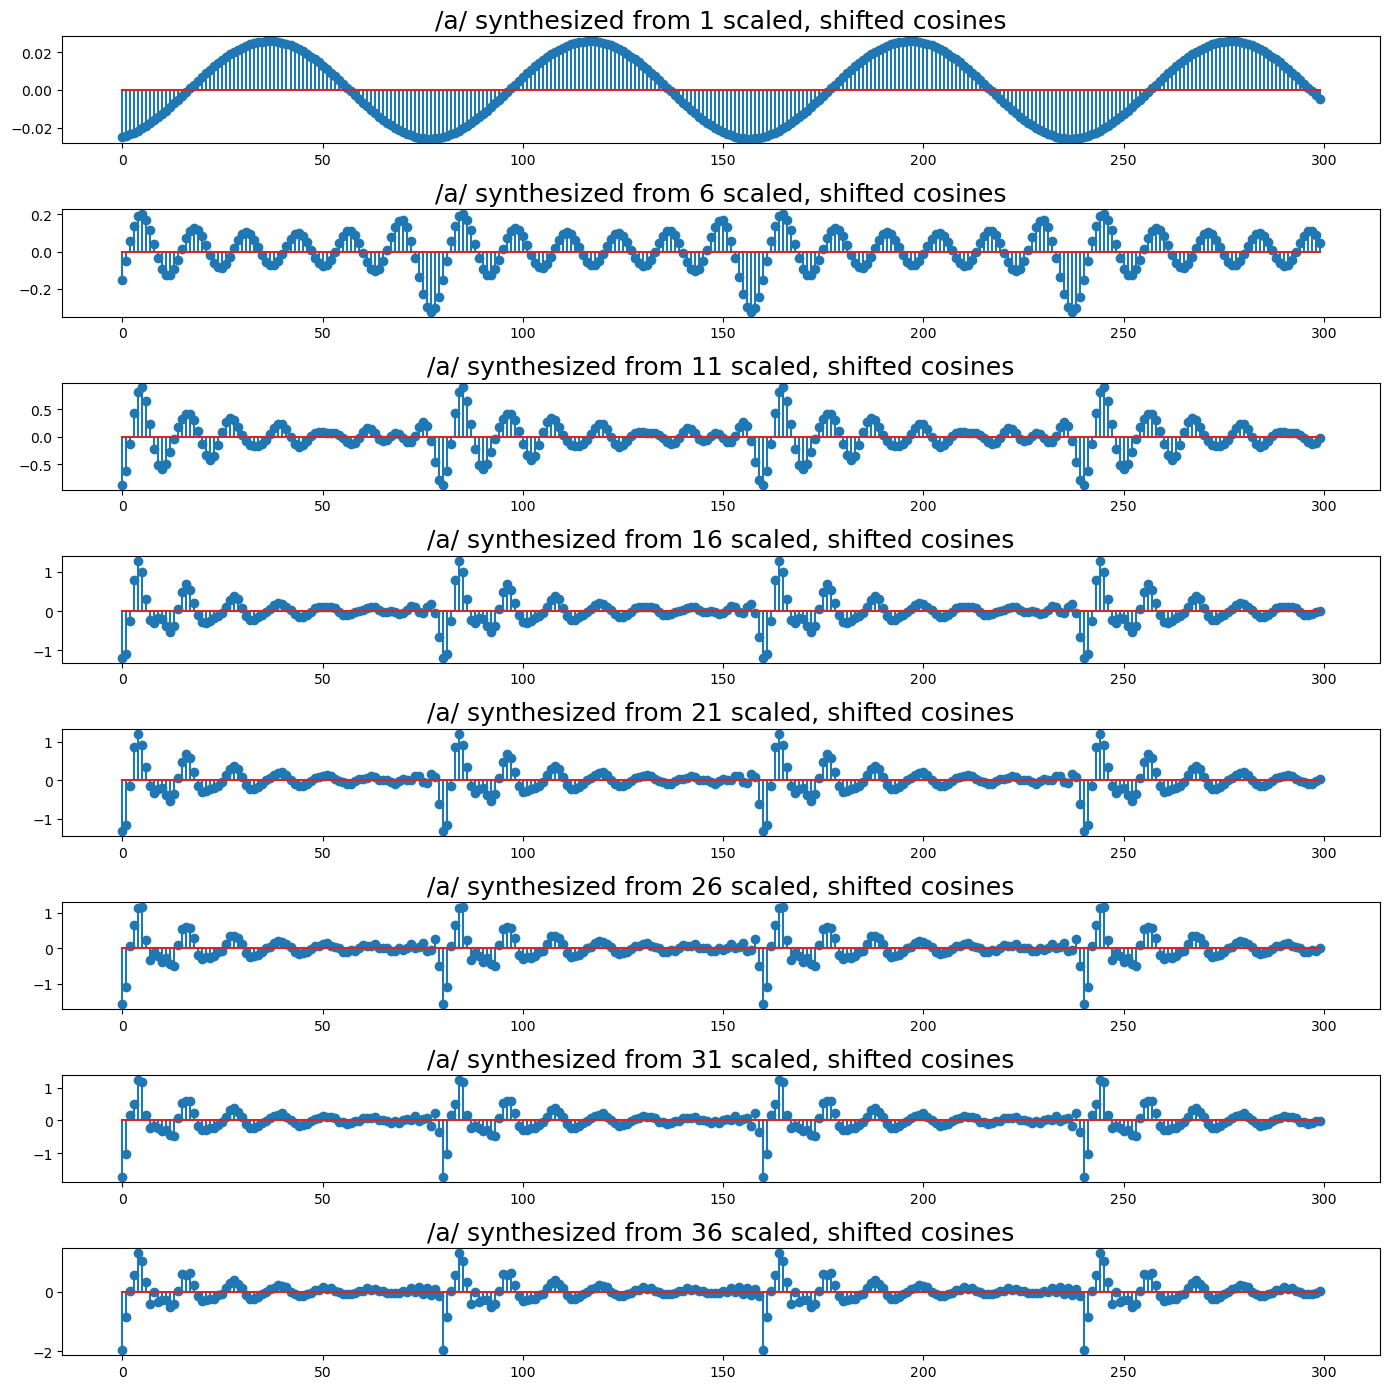

In [9]:
N = 8000
x = np.zeros(N)
n = np.arange(N)

fig = plt.figure(figsize=(14,14),layout='tight')
subplot = fig.subplots(8,1)

for l in range(1,T0//2):
    x = x + (2/N) * np.abs(speech_fft[l*N//T0]) * np.cos(2*np.pi*l*n/T0 + np.angle(speech_fft[l*N//T0])) 
    if (l-1)%5==0:
        subplot[l//5].stem(x[:300])
        subplot[l//5].set_title('/a/ synthesized from %d scaled, shifted cosines'%(l),fontsize=18)
    

In [10]:
IPython.display.Audio(data=x, rate=Fs)

<a id="section3"></a>

## 3. Fourier analysis of other vowels

Let's look at the spectra of all five vowels.

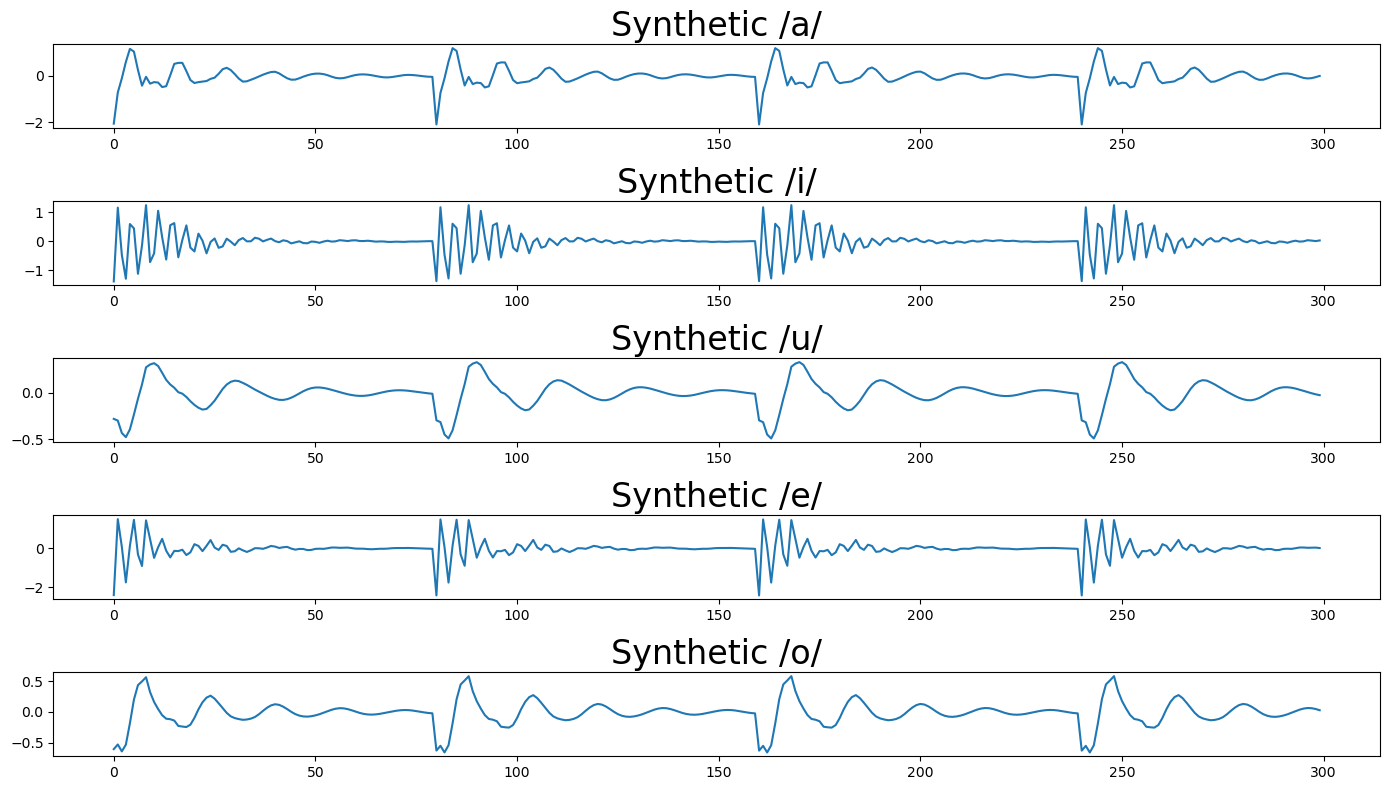

In [11]:
F1 = { 'a':700, 'i':350, 'u':400, 'e':500, 'o':500}
F2 = { 'a':1300, 'i':2300, 'u':800, 'e':2100, 'o':950}
speeches = {}

fig = plt.figure(figsize=(14,8),layout='tight')
subplot = fig.subplots(5,1)
for plotnum, phoneme in enumerate('aiueo'):
    x1 = resonator(excitation,F1[phoneme],100,Fs)
    x2 = resonator(x1, F2[phoneme], 200, Fs)
    x3 = resonator(x2, 2500, 300, Fs)
    speeches[phoneme] = resonator(x3, 3500, 400, Fs)
    subplot[plotnum].plot(speeches[phoneme][:300])
    subplot[plotnum].set_title('Synthetic /%s/'%(phoneme),fontsize=24)

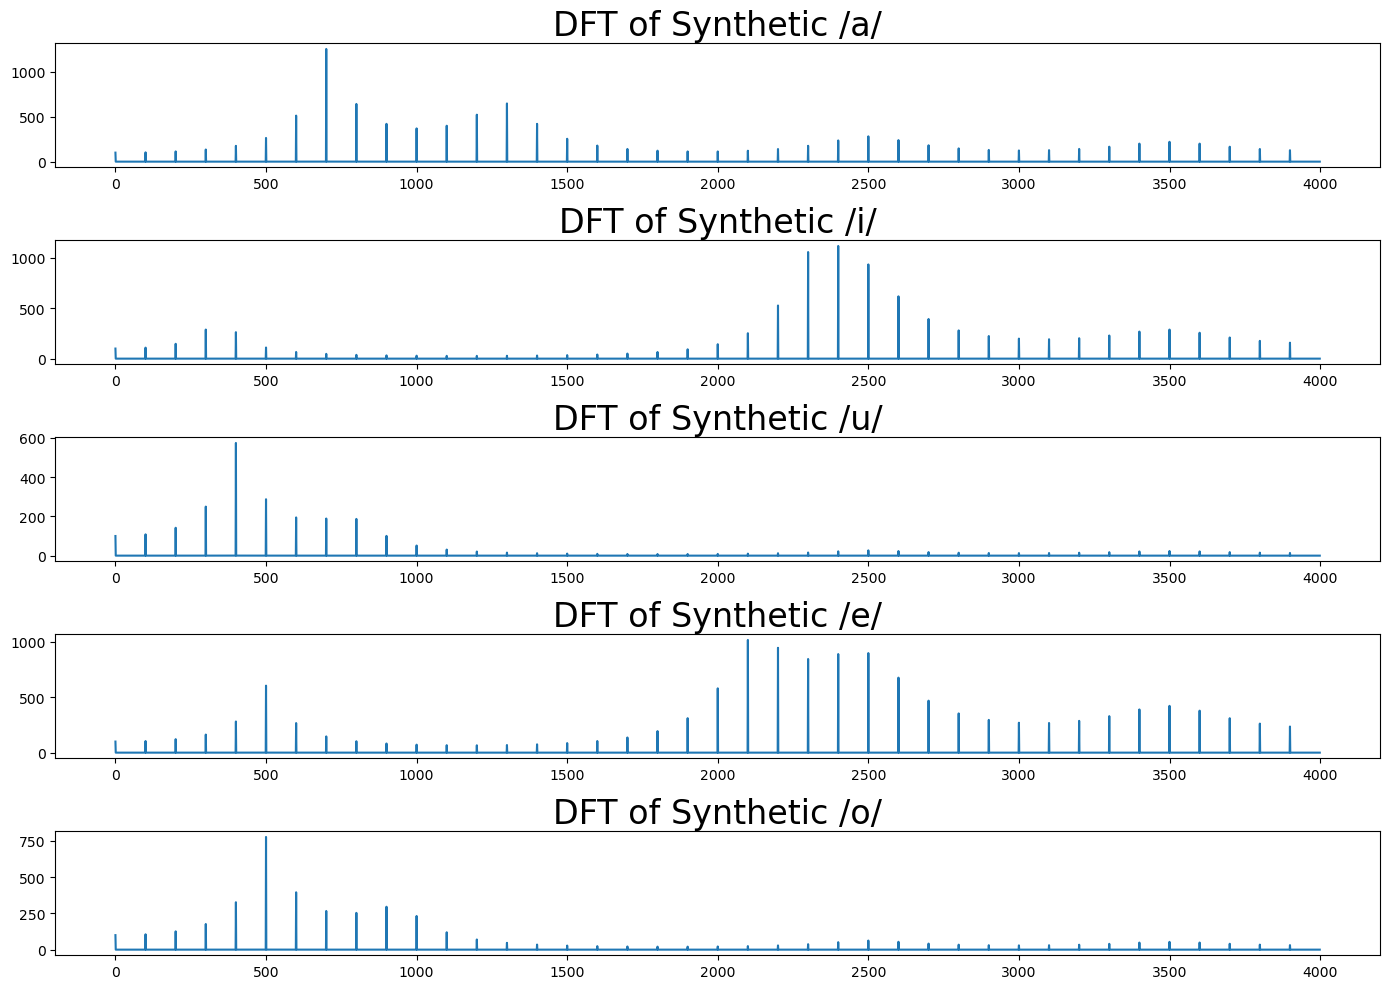

In [12]:
speech_ffts = {}

fig = plt.figure(figsize=(14,10),layout='tight')
subplot = fig.subplots(5,1)
for plotnum, phoneme in enumerate('aiueo'):
    speech_ffts[phoneme] = np.fft.fft(speeches[phoneme])
    subplot[plotnum].plot(np.abs(speech_ffts[phoneme][:4000]))
    subplot[plotnum].set_title('DFT of Synthetic /%s/'%(phoneme),fontsize=24)

Notice that each spectrum has the same $F_0, F3$, and $F_4$, but they have different frequencies of $F_1$ and $F_2$ as given by:

```
F1 = { 'a':700, 'i':350, 'u':400, 'e':500, 'o':500}
F2 = { 'a':1300, 'i':2300, 'u':800, 'e':2100, 'o':950}
```

In [13]:
IPython.display.Audio(data=speeches['e'], rate=Fs)

<a id="homework"></a>

## Homework

For this week's homework, use the Fourier synthesis equation to resynthesize speech with any specified number of harmonics:

$$x[n] =\frac{2}{N} \sum_{l=1}^{\text{num_harmonics}} \left|X\left[\frac{lN}{T_0}\right]\right| \times \cos\left(\frac{2\pi ln}{T_0}+\angle X\left[\frac{lN}{T_0}\right]\right),~~~0\le n\le N-1$$


In [15]:
import importlib, homework9
importlib.reload(homework9)
help(homework9.fourier_synthesis)

Help on function fourier_synthesis in module homework9:

fourier_synthesis(num_harmonics, X, T0)
    Use Fourier synthesis to resynthesize speech from its Fourier transform.
    
    @param:
    num_harmonics (scalar): the number of harmonics to resynthesize
    X (np.ndarray(N)): a length-N Fourier transform
    T0 (scalar): the pitch period, in samples
        
    @result:
    x (np.ndarray(N)): a length-N waveform, resynthesized using Fourier synthesis
    
    The Fourier synthesis equation is this:
    
    x[n] = (2/N) * sum_{l=1}^{num_harmonics} |X[l*N//T0]| * cos(2*pi*l*n/T0 + angle(X[l*N//T0]))



When you get it working, the following code should produce a plot just like the synthesized /a/ earlier:

RuntimeError: You need to change this part

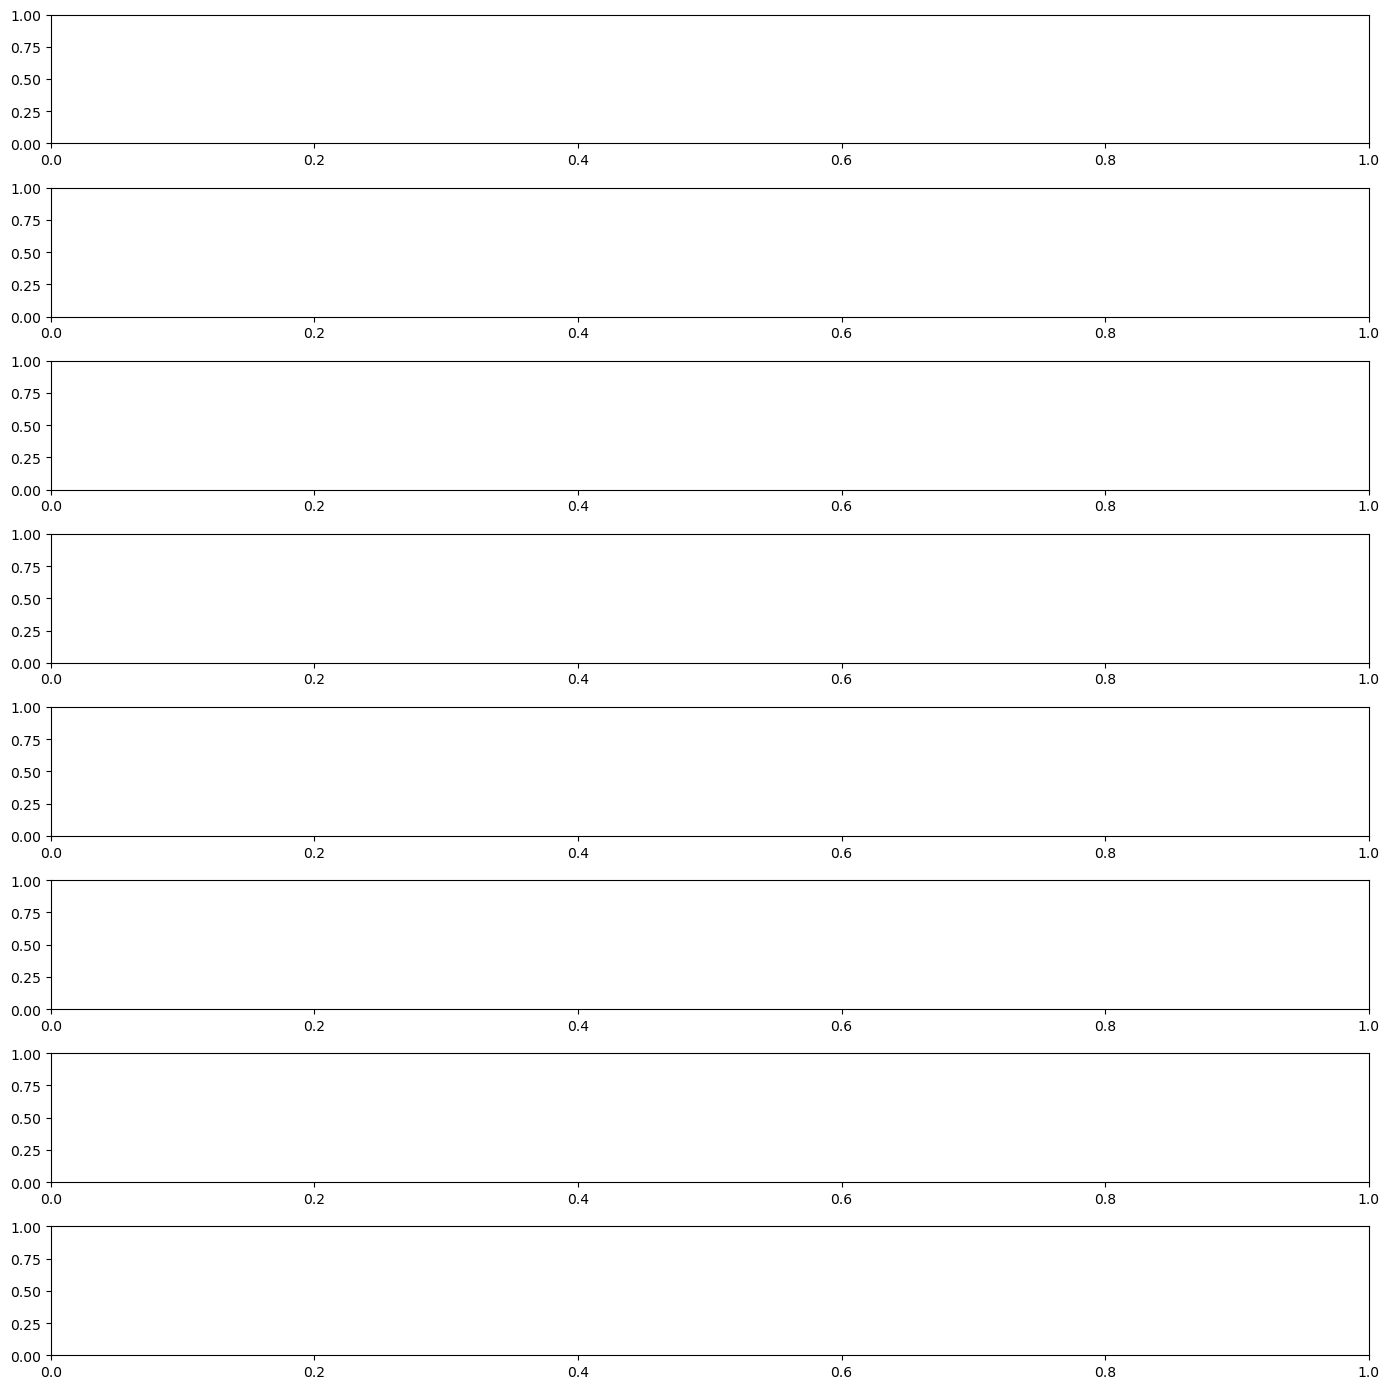

In [16]:
importlib.reload(homework9)

fig = plt.figure(figsize=(14,14),layout='tight')
subplot = fig.subplots(8,1)

for l in [1,6,11,16,21,26,31,36]:
    x = homework9.fourier_synthesis(l, speech_ffts['a'], T0)
    subplot[l//5].stem(x[:300])
    subplot[l//5].set_title('/a/ synthesized from %d scaled, shifted cosines'%(l),fontsize=18)
    

In [17]:
import IPython
IPython.display.Audio(data=x,rate=Fs)

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [18]:
import importlib, grade
importlib.reload(grade)

EEE
ERROR: test_synthesis_correct_length (grade.Test)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/2023_fall/lec09/grade.py", line 11, in test_synthesis_correct_length
    x = homework9.fourier_synthesis(20, X, 80)
  File "/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/2023_fall/lec09/homework9.py", line 19, in fourier_synthesis
    raise RuntimeError("You need to change this part")
RuntimeError: You need to change this part

ERROR: test_synthesis_magnitude (grade.Test)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/2023_fall/lec09/grade.py", line 16, in test_synthesis_magnitude
    x = homework9.fourier_synthesis(20, X, 80)
  File "/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_unde

0 successes out of 3 tests run
Score: 0%
0 successes out of 3 tests run
Score: 0%


<module 'grade' from '/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/2023_fall/lec09/grade.py'>